In [1]:
import pandas as pd

In [31]:
df = pd.read_csv('H1.csv')

In [32]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [33]:
df.dtypes

IsCanceled                       int64
LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber            int64
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                         int64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType             

In [34]:
for col in df.columns:
    type_ = df[col].dtype
    print(col, ' : ', type_, '\t')
    if type_ == 'object':
        print('Number of uniqe values: ', df[col].nunique(), ', Uniqe values: ' , df[col].unique())
        

IsCanceled  :  int64 	
LeadTime  :  int64 	
ArrivalDateYear  :  int64 	
ArrivalDateMonth  :  object 	
Number of uniqe values:  12 , Uniqe values:  ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
ArrivalDateWeekNumber  :  int64 	
ArrivalDateDayOfMonth  :  int64 	
StaysInWeekendNights  :  int64 	
StaysInWeekNights  :  int64 	
Adults  :  int64 	
Children  :  int64 	
Babies  :  int64 	
Meal  :  object 	
Number of uniqe values:  5 , Uniqe values:  ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']
Country  :  object 	
Number of uniqe values:  125 , Uniqe values:  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JA

In [35]:
data_types = {c:'category' for c in df.columns if df[c].dtype=='object'}
data_types

{'ArrivalDateMonth': 'category',
 'Meal': 'category',
 'Country': 'category',
 'MarketSegment': 'category',
 'DistributionChannel': 'category',
 'ReservedRoomType': 'category',
 'AssignedRoomType': 'category',
 'DepositType': 'category',
 'Agent': 'category',
 'Company': 'category',
 'CustomerType': 'category',
 'ReservationStatus': 'category',
 'ReservationStatusDate': 'category'}

In [36]:
df = df.astype(data_types)

In [37]:
df.dtypes

IsCanceled                        int64
LeadTime                          int64
ArrivalDateYear                   int64
ArrivalDateMonth               category
ArrivalDateWeekNumber             int64
ArrivalDateDayOfMonth             int64
StaysInWeekendNights              int64
StaysInWeekNights                 int64
Adults                            int64
Children                          int64
Babies                            int64
Meal                           category
Country                        category
MarketSegment                  category
DistributionChannel            category
IsRepeatedGuest                   int64
PreviousCancellations             int64
PreviousBookingsNotCanceled       int64
ReservedRoomType               category
AssignedRoomType               category
BookingChanges                    int64
DepositType                    category
Agent                          category
Company                        category
DaysInWaitingList                 int64


In [43]:
df['YearWeek'] = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)

In [45]:
df.sort_values(by='YearWeek', ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,YearWeek
0,0,342,2015,July,27,1,0,0,2,0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,201527
114,1,101,2015,July,27,4,2,6,2,0,...,240,NULL,0,Transient,96.30,0,1,Canceled,2015-05-12,201527
115,0,109,2015,July,27,4,2,6,2,0,...,240,NULL,0,Transient,123.00,0,1,Check-Out,2015-07-12,201527
116,0,92,2015,July,27,4,4,6,2,0,...,40,NULL,0,Contract,71.55,0,1,Check-Out,2015-07-14,201527
117,0,92,2015,July,27,4,4,6,2,0,...,40,NULL,0,Contract,71.55,0,1,Check-Out,2015-07-14,201527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33774,0,7,2017,March,9,2,0,1,1,0,...,NULL,331,0,Transient,54.00,0,0,Check-Out,2017-03-03,20179
33777,0,16,2017,March,9,2,0,1,2,1,...,240,NULL,0,Transient,100.00,1,2,Check-Out,2017-03-03,20179
33778,0,1,2017,March,9,2,0,1,1,0,...,NULL,NULL,0,Transient-Party,68.00,0,0,Check-Out,2017-03-03,20179
33757,0,1,2017,March,9,1,0,1,2,2,...,240,NULL,0,Transient,93.00,0,0,Check-Out,2017-03-02,20179


In [47]:
cancelled_per_week = df.groupby('YearWeek').apply(lambda x: sum(x['IsCanceled']))

<AxesSubplot:xlabel='YearWeek'>

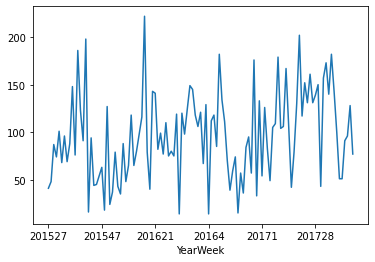

In [48]:
cancelled_per_week.plot()